In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load Data

In [2]:
# Data Source: http://deeplearning.net/data/mnist/
import pickle
import gzip

with gzip.open("data/mnist.pkl.gz", "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
    
print(x_train.shape, y_train.shape)

(50000, 784) (50000,)


5


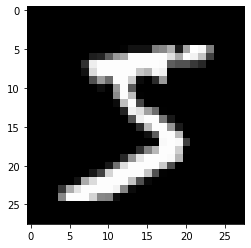

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
print(y_train[0])

In [4]:
x_train, y_train, x_valid, y_valid = map(torch.from_numpy, (x_train, y_train, x_valid, y_valid))
print(x_train.shape, y_train.shape)

torch.Size([50000, 784]) torch.Size([50000])


# Neural Network with torch.nn

In [5]:
class MnistLogistic(nn.Module):
    def __init__(self):
        super(MnistLogistic, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        return self.fc(x)

In [6]:
lr = 0.5
epochs = 2
batch_size = 64
N = x_train.shape[0]

model = MnistLogistic()
optimizer = optim.SGD(model.parameters(), lr=lr)
# Equivalent to log_softmax -> NLLLoss
loss_fn = nn.CrossEntropyLoss()

x0 = x_train[:batch_size]
y0 = y_train[:batch_size]

print(model(x0).shape, y0.shape)
# The loss before training
print(loss_fn(model(x0), y0))

for epoch in range(epochs):
    for i in range((N - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = (i+1) * batch_size
        x = x_train[start_i:end_i]
        y = y_train[start_i:end_i]
        
        # Forward pass + Calculate loss
        loss = loss_fn(model(x), y)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

# The loss after training
# Compare the loss w.r.t. the same batch
print(loss_fn(model(x0), y0))

torch.Size([64, 10]) torch.Size([64])
tensor(2.2839, grad_fn=<NllLossBackward>)
tensor(0.2283, grad_fn=<NllLossBackward>)


# Refactor using Dataset and DataLoader
Use validation set. 

In [7]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataset = TensorDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size*2)

lr = 0.5
epochs = 5
batch_size = 64
N = x_train.shape[0]
N_valid = x_valid.shape[0]

model = MnistLogistic()
optimizer = optim.SGD(model.parameters(), lr=lr)
# Equivalent to log_softmax -> NLLLoss
loss_fn = nn.CrossEntropyLoss()

# The accuracy before training
model.eval()
with torch.no_grad():
    valid_true = sum([(torch.argmax(model(x), dim=1) == y).sum().item() for x, y in valid_dataloader])
print(-1, valid_true / N_valid)
model.train()

for epoch in range(epochs):
    # Avoid explicit indexing now...
    for x, y in train_dataloader:
        # Forward pass + Calculate loss
        loss = loss_fn(model(x), y)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

    # The accuracy during & after training
    model.eval()
    with torch.no_grad():
        valid_true = sum([(torch.argmax(model(x), dim=1) == y).sum().item() for x, y in valid_dataloader])
    print(epoch, valid_true / N_valid)
    model.train()

-1 0.1286
0 0.9112
1 0.9178
2 0.9204
3 0.9218
4 0.9231


# Switch to CNN

In [8]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        # 1 input channels, 16 output channels
        # Image shape: 28*28 -> 14*14
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        # 16 input channels, 16 output channels
        # Image shape: 14*14 -> 7*7
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        # 16 input channels, 10 output channels
        # Image shape: 7*7 -> 4*4
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # Image shape: 7*7 -> 1*1
        x = F.avg_pool2d(x, 4)
        return x.view(-1, x.size(1))

In [9]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataset = TensorDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size*2)

lr = 0.05
epochs = 5
batch_size = 64
N = x_train.shape[0]
N_valid = x_valid.shape[0]

model = MnistCNN()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# Equivalent to log_softmax -> NLLLoss
loss_fn = nn.CrossEntropyLoss()

# The accuracy before training
model.eval()
with torch.no_grad():
    valid_true = sum([(torch.argmax(model(x), dim=1) == y).sum().item() for x, y in valid_dataloader])
print(-1, valid_true / N_valid)
model.train()

for epoch in range(epochs):
    # Avoid explicit indexing now...
    for x, y in train_dataloader:
        # Forward pass + Calculate loss
        loss = loss_fn(model(x), y)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

    # The accuracy during & after training
    model.eval()
    with torch.no_grad():
        valid_true = sum([(torch.argmax(model(x), dim=1) == y).sum().item() for x, y in valid_dataloader])
    print(epoch, valid_true / N_valid)
    model.train()

-1 0.0971
0 0.8306
1 0.9179
2 0.9296
3 0.9385
4 0.9458


# nn.Sequential

In [10]:
class Lambda(nn.Module):
    """
    This is a wrapper class, transforming a Python-function to a PyTorch layer. 
    """
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [11]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataset = TensorDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size*2)

lr = 0.05
epochs = 5
batch_size = 64
N = x_train.shape[0]
N_valid = x_valid.shape[0]

model = nn.Sequential(
    Lambda(lambda x: x.view(-1, 1, 28, 28)), 
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(), 
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(), 
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(), 
    nn.AvgPool2d(4), 
    Lambda(lambda x: x.view(-1, 10)), 
)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# Equivalent to log_softmax -> NLLLoss
loss_fn = nn.CrossEntropyLoss()

# The accuracy before training
model.eval()
with torch.no_grad():
    valid_true = sum([(torch.argmax(model(x), dim=1) == y).sum().item() for x, y in valid_dataloader])
print(-1, valid_true / N_valid)
model.train()

for epoch in range(epochs):
    # Avoid explicit indexing now...
    for x, y in train_dataloader:
        # Forward pass + Calculate loss
        loss = loss_fn(model(x), y)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

    # The accuracy during & after training
    model.eval()
    with torch.no_grad():
        valid_true = sum([(torch.argmax(model(x), dim=1) == y).sum().item() for x, y in valid_dataloader])
    print(epoch, valid_true / N_valid)
    model.train()

-1 0.1064
0 0.8652
1 0.9167
2 0.9176
3 0.9199
4 0.9307
